# Source notebook for generating videos

In [1]:
# default_exp utils_videos

In [2]:
# hide
import sys
sys.path.insert(0, "..")
import nbdev
from nbdev.showdoc import *

In [ ]:
# export
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

import deeptrack as dt

C:\Users\Gorka\Anaconda3\lib\site-packages\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
C:\Users\Gorka\Anaconda3\lib\site-packages\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


## 1. Generate test trajectories

### 1.1. Multi state diffusion

In [39]:
# hide
import numpy as np
from andi_datasets.models_phenom import models_phenom

In [40]:
T = 30 # number of time steps (frames)
N = 56# number of particles (trajectories)
L = 1.5 * 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)

In [41]:
trajs_model2, labels_model2 = models_phenom().multi_state(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    M=np.array([[0.98, 0.02], [0.02, 0.98]]),
)

In [7]:
test = np.moveaxis(trajs_model2, 0, 1)

In [8]:
len(trajs_model2[-1])

56

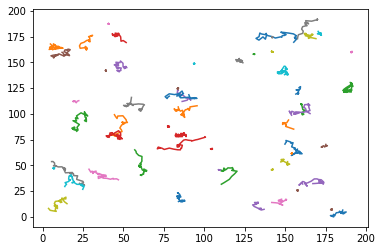

In [9]:
reshaped_trajs = np.moveaxis(trajs_model2, 0, 1)
for traj in reshaped_trajs:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

## 2. Function to generate videos

In [ ]:
# export
def func_poisson_noise():
    def inner(image):
        image[image<0] = 0
        rescale = 1
        noisy_image = np.random.poisson(image * rescale) / rescale
        return noisy_image
    return inner

In [ ]:
# export
def mask(circle_radius, particle_list=[]):
    def inner(image):
        X, Y = np.mgrid[:2*circle_radius, :2*circle_radius]
        CIRCLE = (X - circle_radius+0.5)**2 + (Y- circle_radius+0.5)**2 < circle_radius**2
        CIRCLE = np.expand_dims(CIRCLE, axis=-1)
        _index = image.get_property("replicate_index")[0]
        if particle_list:
            if _index in particle_list:
                pix_val = (_index + 1) * CIRCLE
            else:
                pix_val = 0 * CIRCLE
        else:
            pix_val = (_index + 1) * CIRCLE
        return pix_val
    return inner

In [12]:
# export
def transform_to_video(
    trajectory_data, particle_props={}, optics_props={}, background_props={}, get_vip_particles=[], with_masks=False
):
    """Generates a video from a trajectory data.

    Function needs to called with update().resolve() to create the video.

    Parameters
    ----------
    trajectory_data : np.ndarray
        Generated through models_phenom. Array of shape (T, N, 2) containing the trajectories.
    particle_props : dict
        Dictionary of properties for the particles.
    optics_props : dict
        Dictionary of properties for the optics.
    background_props : dict
        Dictionary of properties for the background.
    """

    _particle_dict = {
        "particle_intensity": [100, 20],                                # Mean and standard deviation of the particle intensity
        "intensity": lambda particle_intensity: particle_intensity[0]
        + np.random.randn() * particle_intensity[1],
        "intensity_variation": 5,                                       # Intensity variation of particle (in standard deviation)
        "z": 0,                                                         # Particles are always at focus - this shouldn't be changed
        "refractive_index": 1.45,                                       # Refractive index of the particle
        "position_unit": "pixel",
    }

    _optics_dict = {
        "NA": 1.46,                 # Numerical aperture
        "wavelength": 500e-9,       # Wavelength
        "resolution": 100e-9,       # Camera resolution or effective resolution
        "magnification": 1,
        "upscale": 4,
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, 128, 128],
    }

    # Background offset
    _background_dict = {
        "background_mean": 10,      # Mean background intensity
        "background_std": 2,        # Standard deviation of background intensity within a video
    }

    # Update the dictionaries with the user-defined values
    _particle_dict.update(particle_props)
    _optics_dict.update(optics_props)
    _background_dict.update(background_props)

    # Reshape the trajectory
    trajectory_data = np.moveaxis(trajectory_data, 0, 1)

    # Generate point particles
    particle = dt.PointParticle(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        **_particle_dict,
    )

    # Intensity variation of particles - controlled by "intensity_variation"
    def intensity_noise(previous_values, previous_value):
        return (previous_values or [previous_value])[0] + _particle_dict[
            "intensity_variation"
        ] * np.random.randn()

    # Make it sequential
    sequential_particle = dt.Sequential(
        particle,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        intensity=intensity_noise,
    )

    # Adding background offset
    background = dt.Add(
        value=_background_dict["background_mean"]
        + np.random.randn() * _background_dict["background_std"]
    )

    def background_variation(previous_values, previous_value):
        return (previous_values or [previous_value])[
            0
        ] + np.random.randn() * _background_dict["background_std"]

    ## This will change the background offset within a sequence with a given standard deviation
    sequential_background = dt.Sequential(background, value=background_variation)

    # Define optical setup
    optics = dt.Fluorescence(**_optics_dict)

    # Scale factor for image plane peak intensity
    scale_image = dt.Multiply(20)

    # Poisson noise
    poisson_noise = dt.Lambda(func_poisson_noise)

    # Sample
    sample = (
        optics(sequential_particle ^ sequential_particle.number_of_particles)
        >> scale_image
        >> sequential_background
        >> poisson_noise
    )

    # Masks
    get_masks = dt.SampleToMasks(
        lambda: mask(circle_radius=1, particle_list=get_vip_particles),
        fov =  optics.output_region,
        output_region=lambda fov: [fov[0], fov[1], fov[2]-fov[0], fov[3]-fov[1]],
        merge_method="add",
    )

    masks = sample >> get_masks

    # Sequential sample
    sequential_sample = dt.Sequence(
        (sample & masks),
        trajectory=particle.trajectories,
        sequence_length=particle.traj_length,
    )

    # Resolve the sample
    _video, _masks = sequential_sample.update().resolve()

    if with_masks==True:
        final_output = (_video, _masks)
    elif get_vip_particles:
        final_output = (_masks[0], *_video)
    else:
        final_output = _video

    return final_output

## 3. Testing function

In [47]:
origin = 0
width = 128
video = get_video_andi(
    trajs_model2,

    optics_props={
        "output_region":[origin, origin, origin + width, origin + width],
    },

    get_vip_particles=[1,2,3,]
)

Text(0.5, 1.0, 'Mask')

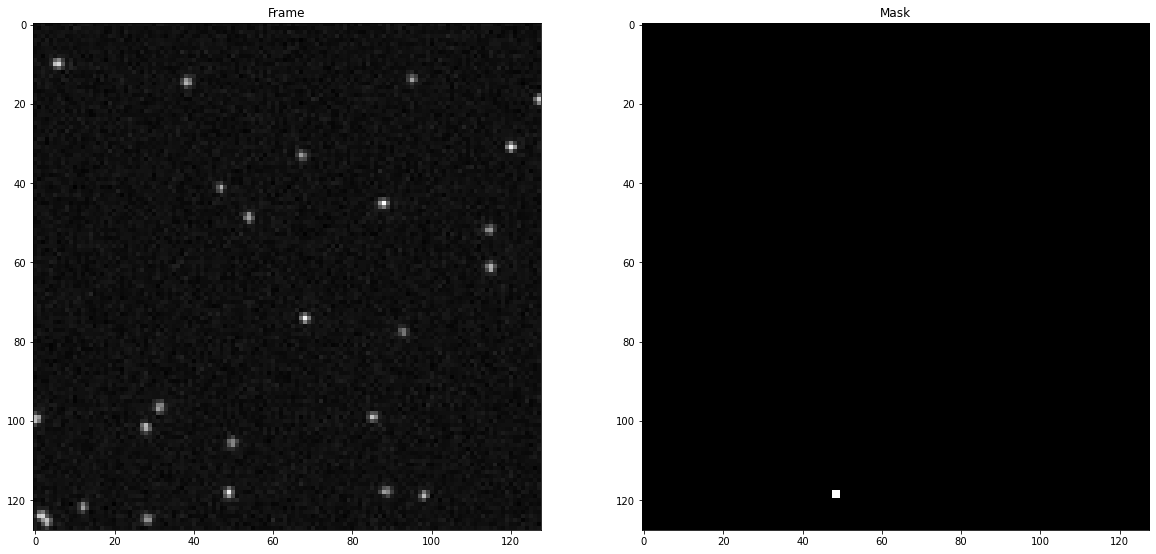

In [45]:
from matplotlib.patches import Rectangle
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 10))
img1 = ax0.imshow(video[0], cmap="gray")
ax0.set_title("Frame")
img2 = ax1.imshow(masks[0], cmap="gray")
ax1.set_title("Mask")

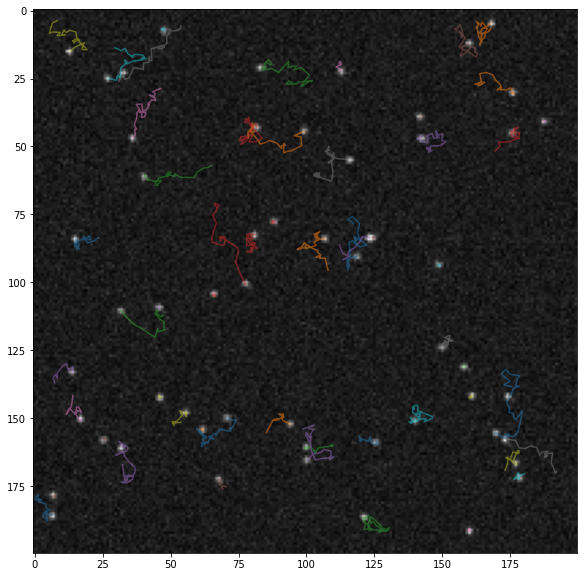

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(video[0], cmap="gray")
for traj in np.moveaxis(trajs_model2, 0, 1):
    plt.plot(traj[:,1], traj[:,0], alpha=0.5)
plt.show()


In [16]:
# export
def play_video(video, figsize=(5, 5), fps=10):
    """Visualizes the stack of images.

    Parameters
    ----------
    video : ndarray
        Stack of images.
    figsize : tuple, optional
        Size of the figure.
    fps : int, optional
        Frames per second.
    """

    fig = plt.figure(figsize=figsize)
    images = []
    plt.axis("off")

    for image in video:
        images.append([plt.imshow(image[:, :, 0], cmap="gray")])

    anim = animation.ArtistAnimation(
        fig, images, interval=1e3 / fps, blit=True, repeat_delay=0
    )

    return HTML(anim.to_jshtml())

Save the notebook before running the below cell. It will erase all the source files otherwise

In [38]:
from nbdev.export import notebook2script
notebook2script()

Converted analysis.ipynb.
Converted datasets_challenge.ipynb.
Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
Converted utils_videos.ipynb.
